<a href="https://colab.research.google.com/github/kvnptl/pytorch-practice/blob/main/02_neural_netowork_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Make classification data and get it ready

In [3]:
import sklearn
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [5]:
print(f'first 5 samples of X:\n {X[:5]}')
print(f'first 5 samples of y:\n {y[:5]}')

first 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y:
 [1 1 1 1 0]


In [6]:
# make dataframe of circle data

import pandas as pd
circles = pd.DataFrame({'X1' : X[:, 0],
                        "X2" : X[:, 1],
                        "y" : y})

circles.head(10)

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


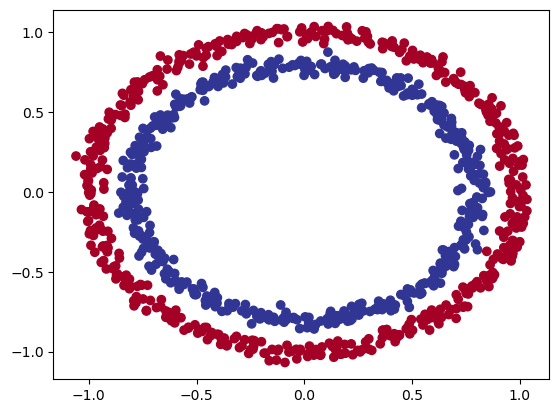

In [7]:
from matplotlib import pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu) # red = 0, blue = 1, c = color, cmap = color map
plt.show()

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into Tensors

In [9]:
import torch
torch.__version__

'2.0.0+cu117'

In [10]:
type(X)

numpy.ndarray

In [11]:
# convert to tensor

# NOTE: As mentioned in the previous sessions, numpy default datatype is float64, whereas pytorch's default datatype is float32

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)



In [12]:
type(X)

torch.Tensor

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #20% of test, 80% train
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## 2. Build a model

In [15]:
from torch import nn
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) #nn.Linear takes care of the weights and biases
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))


model_0 = CircleModel().to(device)

In [17]:
# next(model.parameters())
model_0.state_dict()
# NOTE: the shape of the weights and biases are determined by the in_features and out_features of the nn.Linear() layer
# layer_1 weights = 5 x 2
# layer_1 biases = 5
# layer_2 weights = 1 x 5
# layer_2 biases = 1
# So the weights are determined by the shape of the layer, and the biases are determined by the out_features of the layer


OrderedDict([('layer_1.weight',
              tensor([[-0.4432, -0.1167],
                      [ 0.0600,  0.4213],
                      [ 0.6346,  0.4157],
                      [-0.6451, -0.5649],
                      [ 0.0257,  0.0547]])),
             ('layer_1.bias',
              tensor([-0.6201,  0.6454,  0.3536, -0.5524,  0.4672])),
             ('layer_2.weight',
              tensor([[ 0.3013, -0.1149, -0.1413,  0.1729,  0.2134]])),
             ('layer_2.bias', tensor([0.4251]))])

In [18]:
# Replicate the model using Sequential 
# instead of using above code block which is class based, we can use the below code
# NOTE: but only for simple implementation, class-based has more flexibility

model_0_seq = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0_seq

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0_seq.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.5675, -0.3239],
                      [ 0.4397, -0.1740],
                      [ 0.2502,  0.5011],
                      [-0.5306, -0.1492],
                      [-0.3238,  0.0704]])),
             ('0.bias', tensor([-0.5866, -0.4628,  0.1654,  0.4780,  0.1829])),
             ('1.weight',
              tensor([[ 0.2000,  0.1249, -0.1299,  0.4062,  0.1062]])),
             ('1.bias', tensor([0.0208]))])

In [20]:
# Make predictions

with torch.inference_mode():
  untrained_model = model_0(X_test.to(device))
untrained_model[:10], untrained_model.shape

(tensor([[ 0.0887],
         [-0.1059],
         [ 0.4265],
         [-0.0063],
         [ 0.1529],
         [ 0.0362],
         [-0.2949],
         [-0.2624],
         [ 0.4375],
         [-0.1220]]),
 torch.Size([200, 1]))

# Next chapter: 69 | Loss, optimizer, ...

In [21]:
# Loss and optimizer

loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [22]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  # Here .item() is used to convert tensor to scalar 
  acc = (correct/len(y_pred)) * 100
  return acc

### Train model

Steps:

1. Forward pass
2. Calculate the loss
3. Oprimizer zero grad
4. Loss backward (backpropogation)
5. Optimizer step (gradient step)

Going from raw logits -> prediction probabilities -> prediction labels

- We can convert **logits** into **prediction probabilities** by passing them to some kind of activation function (eg. sigmoid for binary classification and softmax for multiclass classification)
- Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [23]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0887],
        [-0.1059],
        [ 0.4265],
        [-0.0063],
        [ 0.1529]])

In [24]:
# we need something like this
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# convert logits to probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5222],
        [0.4735],
        [0.6050],
        [0.4984],
        [0.5382]])

In [26]:
# convert probabilities to labels
y_pred = torch.round(y_pred_probs)
y_pred

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])

### Training loop

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42) # cuda seed is used to make sure the results are reproducible in GPU as well

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build a training loop
for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze() # squeeze() is used to remove the extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calc loss/acc
  loss = loss_fn(y_logits, # because we are using BCEWithLogitsLoss
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Zero grad
  optimizer.zero_grad()

  # 4. Loss backwards (calculate gradients)
  loss.backward()

  # 5. Optimizer step (update weights and biases)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)
    
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70529, Acc: 51.12% | Test loss: 0.69478, Test acc: 51.50%
Epoch: 10 | Loss: 0.70286, Acc: 51.12% | Test loss: 0.69354, Test acc: 52.00%
Epoch: 20 | Loss: 0.70098, Acc: 51.00% | Test loss: 0.69272, Test acc: 52.50%
Epoch: 30 | Loss: 0.69949, Acc: 50.88% | Test loss: 0.69217, Test acc: 52.50%
Epoch: 40 | Loss: 0.69831, Acc: 50.88% | Test loss: 0.69182, Test acc: 52.50%
Epoch: 50 | Loss: 0.69735, Acc: 50.88% | Test loss: 0.69161, Test acc: 52.00%
Epoch: 60 | Loss: 0.69658, Acc: 50.88% | Test loss: 0.69151, Test acc: 52.00%
Epoch: 70 | Loss: 0.69594, Acc: 50.88% | Test loss: 0.69148, Test acc: 52.00%
Epoch: 80 | Loss: 0.69542, Acc: 51.12% | Test loss: 0.69151, Test acc: 52.00%
Epoch: 90 | Loss: 0.69500, Acc: 51.00% | Test loss: 0.69158, Test acc: 52.00%
Epoch: 100 | Loss: 0.69464, Acc: 51.50% | Test loss: 0.69168, Test acc: 51.50%
Epoch: 110 | Loss: 0.69435, Acc: 51.38% | Test loss: 0.69180, Test acc: 51.50%
Epoch: 120 | Loss: 0.69412, Acc: 51.38% | Test loss: 0.69193, T

### Make predictions and evaluate the model

In [28]:
# from the result, it seems like model is not learning anything
# so let's inspect the model

import requests
from pathlib import Path

# Download helper function from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py...")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_decision_boundary

# You can see the helper_functions.py file in the left sidebar


helper_functions.py already exists, skipping download


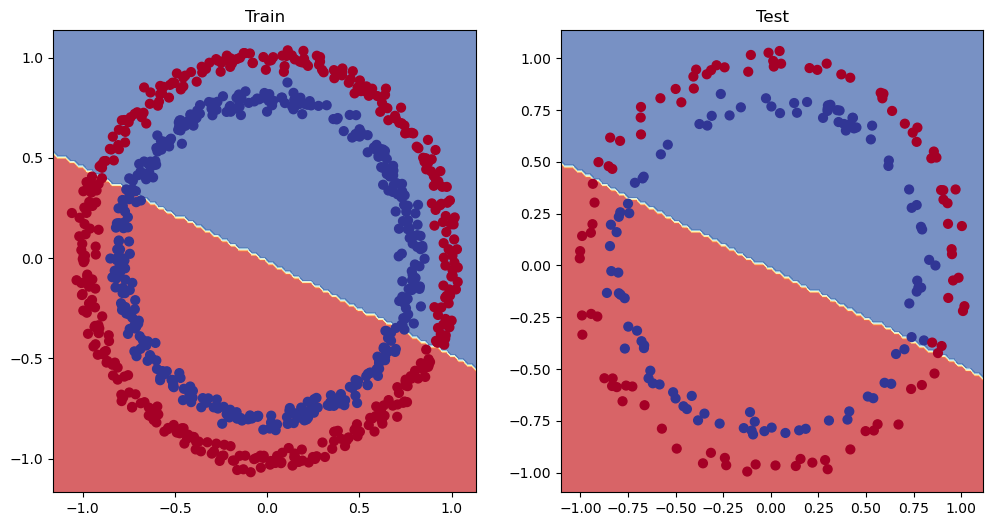

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

### Comment: from the graph, it is clear that the current model is not good enough to classify the data. We need to implement a complex model.

# Next chapter: 73 | Improving our model
Link: https://www.youtube.com/watch?v=Z_ikDlimN6A&t=83869s